## Feature Engineering Unstructured (Privacy data aware!!!) with LLM


<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/llm_could.png" width=800>


In [1]:
# !pip install python-dotenv
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.environ.get('OPENAI_API_KEY')

In [2]:
import pandas as pd
from openai import OpenAI
import concurrent.futures

def ask_chatgpt(model_name: str, client: OpenAI) -> str:
    """
    Call ad API ChatGPT.
    """
    try:
        completion = client.chat.completions.create(
                                                    model="gpt-4o-mini",
                                                    messages=[
                                                            {"role": "system", "content": """Sei un esperto di automobili. Classifica in: 
                                                                                              SUV, Compact, Sedan, Hatchback, MPV, Off-road, Luxury, Sports, NotClassified
                                                                                            """},
                                                            {"role": "user", "content": f"Classifica: {model_name}. Rispondi solo con la categoria."}
                                                            ])
        return completion.choices[0].message.content.strip()
    except:
        return "NotClassified"

def classify_batch(models, api_key: str):
    """
    Classifica un batch di modelli in parallelo.
    """
    client = OpenAI(api_key=api_key)
    results = []
    
    for model in models:
        try:
            car_type = ask_chatgpt(model, client)
            results.append({"model": model, "type": car_type})
        except:
            results.append({"model": model, "type": "NotClassified"})
    
    return results

def process_car_dataset(df: pd.DataFrame, api_key: str, batch_size: int = 10) -> pd.DataFrame:
    """
    Processa il dataset usando batch paralleli
    
    Args:
        df: DataFrame con colonna 'name' contenente i nomi macchine
        api_key: OpenAI API key
        batch_size: Dimensione dei batch per il processing parallelo
    """
    models = df['name'].tolist()
    total_models = len(models)
    results = []    
    batches = [models[i:i + batch_size] for i in range(0, total_models, batch_size)]
    print(f"Classificazione di {total_models} observations")
    
    # Processa i batch in parallelo con i cores
    workers_cpu = 16 # num core
    with concurrent.futures.ThreadPoolExecutor(max_workers=workers_cpu) as executor:
        future_to_batch = {executor.submit(classify_batch, batch, api_key): batch 
                            for batch in batches}
        completed = 0
        for future in concurrent.futures.as_completed(future_to_batch):
            batch_results = future.result()
            results.extend(batch_results)
            completed += len(batch_results)
            print(f"Progresso: {completed}/{total_models} observations classificati")
    
    classifications = {item["model"]: item["type"] for item in results}    
    df['vehicle_type'] = df['name'].map(classifications)

    return df

takes... 30 sec with 16 cores

In [3]:
df = pd.read_csv('cars_cleaned.csv')

batch = 50
df_ = process_car_dataset(df, api_key, batch_size=50)
print("\nClassificazione completata:")
df_

Classificazione di 817 observations
Progresso: 50/817 observations classificati
Progresso: 100/817 observations classificati
Progresso: 150/817 observations classificati
Progresso: 200/817 observations classificati
Progresso: 250/817 observations classificati
Progresso: 300/817 observations classificati
Progresso: 350/817 observations classificati
Progresso: 400/817 observations classificati
Progresso: 450/817 observations classificati
Progresso: 500/817 observations classificati
Progresso: 550/817 observations classificati
Progresso: 600/817 observations classificati
Progresso: 650/817 observations classificati
Progresso: 700/817 observations classificati
Progresso: 750/817 observations classificati
Progresso: 767/817 observations classificati
Progresso: 817/817 observations classificati

Classificazione completata:


,name,year,Price,kms_driven,fuel_type,vehicle_type
0,Hyundai Santro Xing XO eRLX Euro III,2007,800.0,45000,Petrol,NotClassified
1,Mahindra Jeep CL550 MDI,2006,4250.0,40,Diesel,Off-road
2,Hyundai Grand i10 Magna 1.2 Kappa VTVT,2014,3250.0,28000,Petrol,Hatchback
3,Ford EcoSport Titanium 1.5L TDCi,2014,5750.0,36000,Diesel,SUV
4,Ford Figo,2012,1750.0,41000,Diesel,Hatchback
...,...,...,...,...,...,...
812,Toyota Corolla Altis,2009,3000.0,132000,Petrol,Sedan
813,Tata Zest XM Diesel,2018,2600.0,27000,Diesel,Sedan
814,Mahindra Quanto C8,2013,3900.0,40000,Diesel,SUV
815,Honda Amaze 1.2 E i VTEC,2014,1800.0,50000,Petrol,Sedan


In [272]:
#salvo i risultati delle call su un csv
df_.to_csv('cars_classes.csv',index=False)

## Start From Here after ChatGPT Call

In [2]:
import pandas as pd

path = 'cars_classes.csv'
df_ = pd.read_csv(path)
df = df_.copy()
df

,name,year,Price,kms_driven,fuel_type,vehicle_type
0,Hyundai Santro Xing XO eRLX Euro III,2007,800.0,45000,Petrol,NotClassified
1,Mahindra Jeep CL550 MDI,2006,4250.0,40,Diesel,Off-road
2,Hyundai Grand i10 Magna 1.2 Kappa VTVT,2014,3250.0,28000,Petrol,Hatchback
3,Ford EcoSport Titanium 1.5L TDCi,2014,5750.0,36000,Diesel,SUV
4,Ford Figo,2012,1750.0,41000,Diesel,Hatchback
...,...,...,...,...,...,...
812,Toyota Corolla Altis,2009,3000.0,132000,Petrol,Sedan
813,Tata Zest XM Diesel,2018,2600.0,27000,Diesel,Sedan
814,Mahindra Quanto C8,2013,3900.0,40000,Diesel,MPV
815,Honda Amaze 1.2 E i VTEC,2014,1800.0,50000,Petrol,Sedan


In [3]:
#rimuovo outliers sopra i 20000
df= df[df['Price']< 20000]

In [4]:
df['vehicle_type'].value_counts()

vehicle_type
Hatchback        266
Sedan            198
SUV              110
Compact           92
MPV               78
Off-road          37
NotClassified     26
Luxury             2
Name: count, dtype: int64

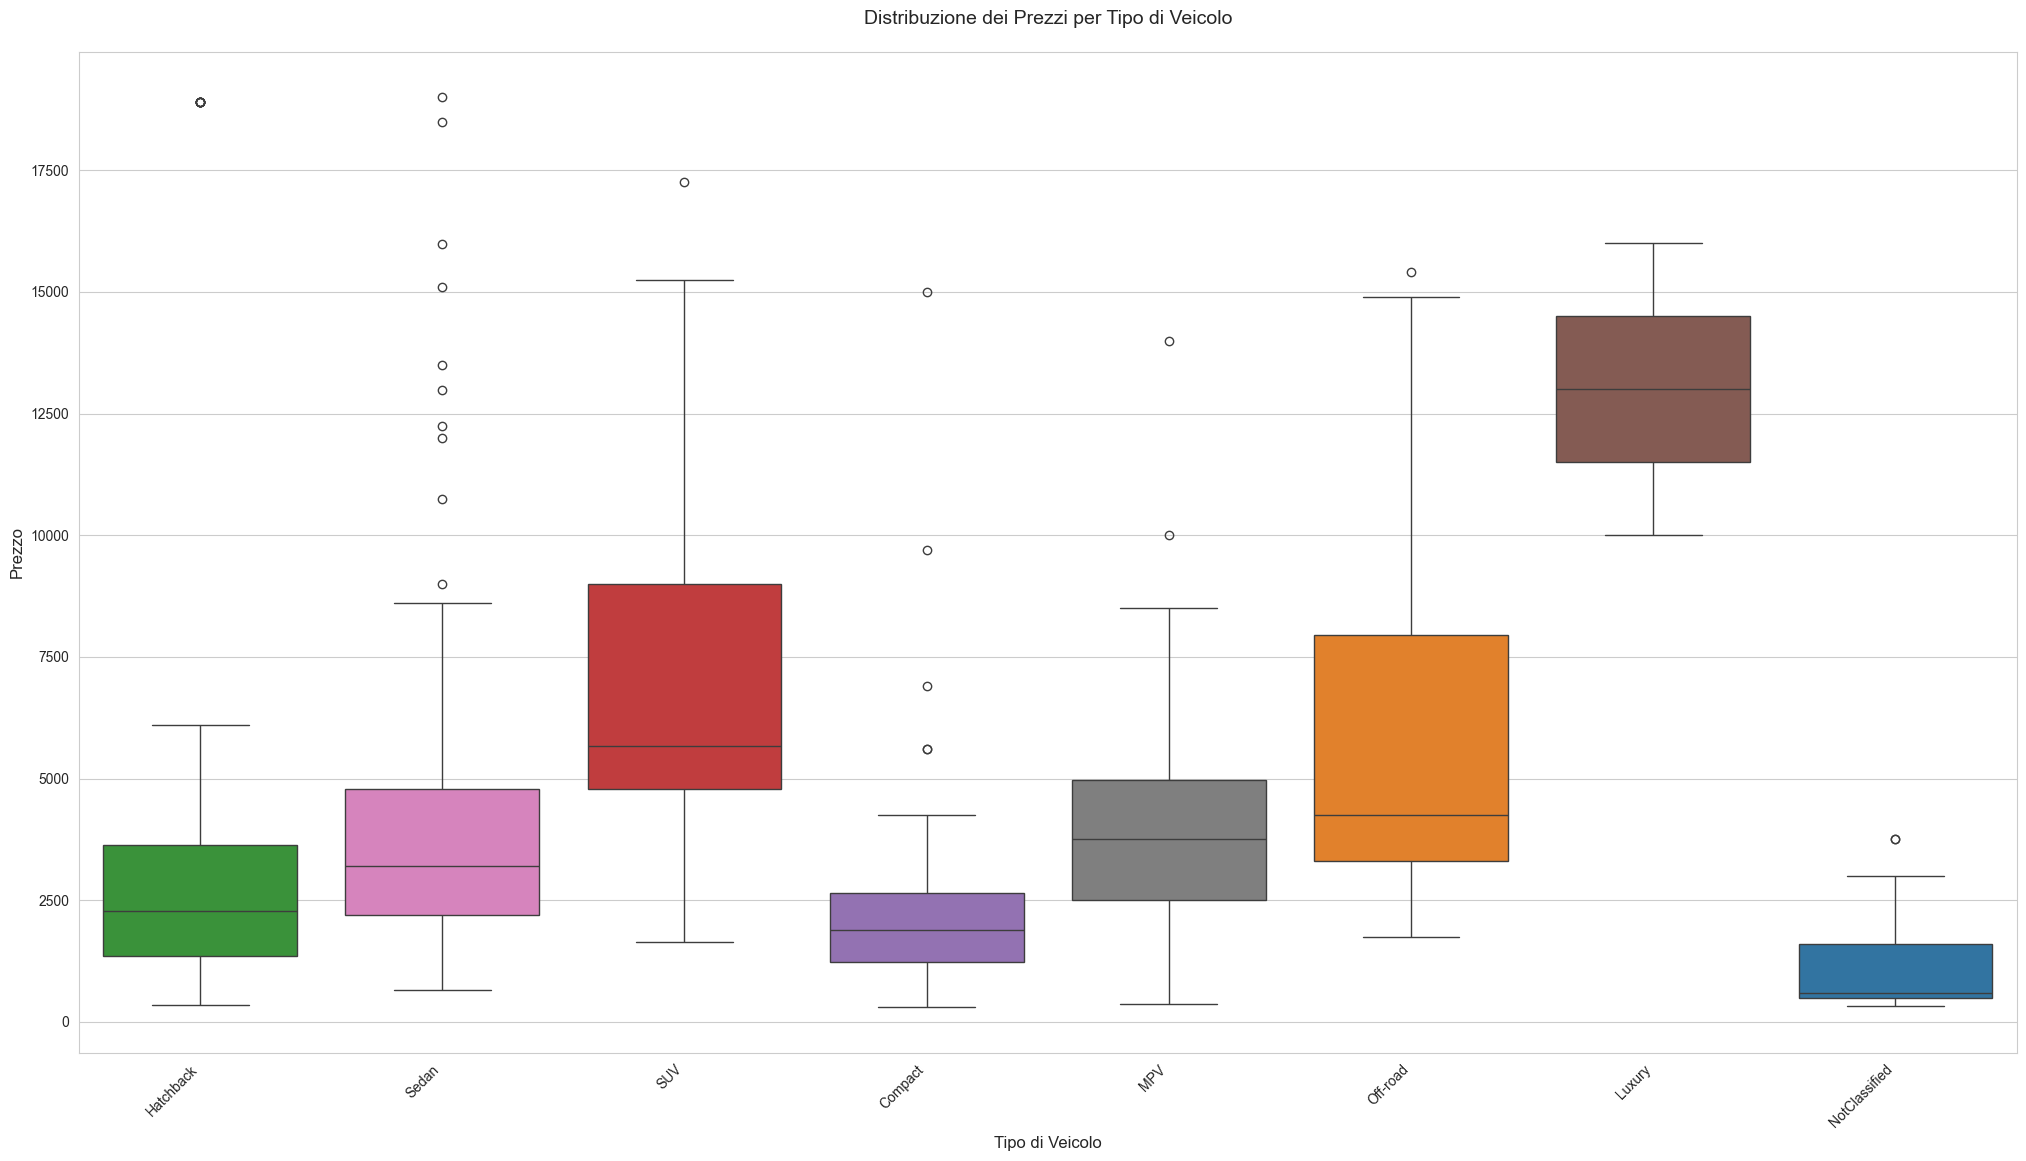

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(25,13))

box_plot = sns.boxplot(
                        data=df,
                        x='vehicle_type',
                        y='Price',
                        hue='vehicle_type',
                        order=['Hatchback', 'Sedan', 'SUV', 'Compact', 'MPV', 'Off-road', 'Luxury', 'NotClassified']
                        )

plt.title('Distribuzione dei Prezzi per Tipo di Veicolo', pad=20, size=14)
plt.xlabel('Tipo di Veicolo', size=12)
plt.ylabel('Prezzo', size=12)
plt.xticks(rotation=45, ha='right');

In [ ]:
df['brand'] = df['name'].str.split().str[0]
df = pd.get_dummies(df,columns=['fuel_type', 'brand','vehicle_type'], drop_first=True,dtype=int)
df['old'] = 2024 - df['year']

KeyError: "['fuel_type', 'vehicle_type'] not in index"

### Modeling

In [8]:
drop_columns = ['Price','name','year'] # not useless
TARGET = 'Price'

X = df.drop(columns=drop_columns)
y = df[TARGET]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=667,
                                                    )

In [10]:
from sklearn.metrics import r2_score,mean_squared_error

def overfit_eval(model, X, y):
    """
    model: il nostro modello predittivo già addestrato
    X: una tupla contenente le prorietà del train set e test set (X_train, X_test)
    y: una tupla contenente target del train set e test set (y_train, y_test)
    """
    y_pred_train = model.predict(X[0])
    y_pred_test = model.predict(X[1])
    mse_train = mean_squared_error(y[0], y_pred_train)
    mse_test = mean_squared_error(y[1], y_pred_test)
    r2_train = r2_score(y[0], y_pred_train)
    r2_test = r2_score(y[1], y_pred_test)

    print("Train set:  MSE="+str(mse_train)+" R2="+str(r2_train))
    print("Test set:  MSE="+str(mse_test)+" R2="+str(r2_test))

In [11]:
from sklearn.linear_model import ElasticNet

alphas = [0.0001, 0.001, 0.01, 0.1 ,1 ,10]

for alpha in alphas:
    print("Lambda is: "+str(alpha))
    elastic = ElasticNet(alpha=alpha, l1_ratio=0.5)
    elastic.fit(X_train, y_train)
    overfit_eval(elastic, (X_train, X_test),(y_train, y_test))

Lambda is: 0.0001
Train set:  MSE=2000907.0820943445 R2=0.8260489626727923
Test set:  MSE=4061186.7520544054 R2=0.5314215298680967
Lambda is: 0.001
Train set:  MSE=2139864.055655237 R2=0.8139685867717453
Test set:  MSE=3661058.818411689 R2=0.5775881669744791
Lambda is: 0.01
Train set:  MSE=3068423.846491718 R2=0.7332432296165924
Test set:  MSE=3506121.538315877 R2=0.5954647823842404
Lambda is: 0.1
Train set:  MSE=6206375.97150257 R2=0.4604419425836065
Test set:  MSE=5113175.076266378 R2=0.410043442710073
Lambda is: 1
Train set:  MSE=8588398.905951688 R2=0.2533581833762979
Test set:  MSE=6833655.079960401 R2=0.2115349925346015
Lambda is: 10
Train set:  MSE=9629467.183491677 R2=0.16285177834274756
Test set:  MSE=7588451.522936821 R2=0.12444681262463342


In [12]:
# model = ElasticNet(alpha=0.001, l1_ratio=0.5)
# model.fit(X_train, y_train)

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [14]:
# from xgboost import XGBRegressor

# model = XGBRegressor()
# model.fit(X_train, y_train)

In [15]:
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import r2_score, root_mean_squared_error

r2 = r2_score(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

print(f'R2: {r2}')
print(f'RMSE: {rmse:.2f}')

R2: 0.7189973140474115
RMSE: 1560.60


In [17]:
model.feature_importances_

array([1.21440060e-01, 3.16290715e-04, 1.45237503e-02, 4.46523005e-02,
       2.99021116e-03, 6.50479915e-04, 4.48857116e-05, 5.55898307e-04,
       2.31409173e-03, 2.56328677e-06, 3.42260990e-03, 1.10484507e-02,
       2.91667225e-03, 1.04150786e-02, 8.51968140e-03, 5.17410175e-02,
       2.17355894e-01, 3.50609007e-02, 2.61070922e-04, 3.22484733e-03,
       1.31424129e-03, 1.37366102e-02, 2.25771400e-02, 5.27808683e-03,
       2.82584881e-02, 5.11981403e-03, 8.71610481e-03, 1.17536668e-02,
       7.61401130e-04, 1.18223577e-02, 1.60443591e-01, 2.20307811e-02,
       1.76730962e-01])

(<matplotlib.legend.Legend at 0x1734453e510>,)

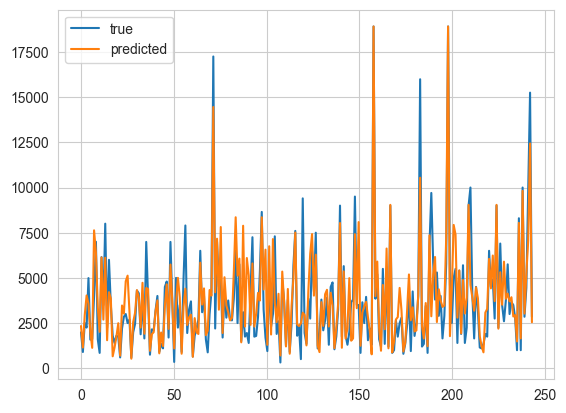

In [18]:
import matplotlib.pyplot as plt
import numpy as np

lenght = len(y_test)
x = np.linspace(0,lenght,lenght)
plt.plot(x,y_test,label='true')
plt.plot(x,y_pred,label='predicted')
plt.legend(),

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_prediction_errors(y_test, y_pred, X_test, n_worst=10):
    """
    Analizza gli errori di predizione e mostra i casi peggiori.
    """
    # Calcola gli errori
    errors = y_test - y_pred
    abs_errors = np.abs(errors)
    
    # Crea un DataFrame con tutti i dati rilevanti
    error_df = pd.DataFrame({
                            'Actual': y_test,
                            'Predicted': y_pred,
                            'Error': errors,
                            'Abs_Error': abs_errors
                        })
    
    # Aggiungi le feature del test set
    error_df = pd.concat([error_df, X_test.reset_index(drop=True)], axis=1)
    
    # Trova i casi peggiori
    worst_cases = error_df.nlargest(n_worst, 'Abs_Error')
    
    print("=== Statistiche degli Errori ===")
    print(f"Errore medio: {errors.mean():.2f}")
    print(f"Errore mediano: {np.median(errors):.2f}")
    print(f"Deviazione standard errori: {errors.std():.2f}")
    print(f"Errore assoluto medio: {abs_errors.mean():.2f}")
    print("\n=== Casi Peggiori ===")
    print(worst_cases[['Actual', 'Predicted', 'Error', 'Abs_Error']].round(2))
    
    # Inizializzo il subplot fissando gli assi, matrice 1x2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Distribuzione degli errori
    sns.histplot(data=errors, bins=30, ax=ax1)
    ax1.set_title('Distribuzione degli Errori')
    ax1.set_xlabel('Errore')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    
    # Actual vs Predicted
    sns.scatterplot(data=error_df, x='Actual', y='Predicted', ax=ax2, alpha=0.5)
    ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
             'r--', label='Perfect Predictions')
    ax2.set_title('Valori Reali vs Predetti')
    ax2.set_xlabel('Valori Reali')
    ax2.set_ylabel('Valori Predetti')
    ax2.legend()
    #plt.show()
    
    return error_df, worst_cases

=== Statistiche degli Errori ===
Errore medio: -203.08
Errore mediano: -158.43
Deviazione standard errori: 1550.52
Errore assoluto medio: 1023.26

=== Casi Peggiori ===
      Actual  Predicted   Error  Abs_Error
677   9700.0     2876.9  6823.1     6823.1
410   9400.0     3075.7  6324.3     6324.3
511  15990.0    10540.8  5449.2     5449.2
14   10000.0     4615.1  5384.9     5384.9
56    1700.0     6562.8 -4862.8     4862.8
19    3100.0     7885.5 -4785.5     4785.5
508   3500.0     8087.6 -4587.6     4587.6
468   1950.0     6099.4 -4149.4     4149.4
783   3000.0     7148.5 -4148.5     4148.5
442   1400.0     5141.5 -3741.5     3741.5


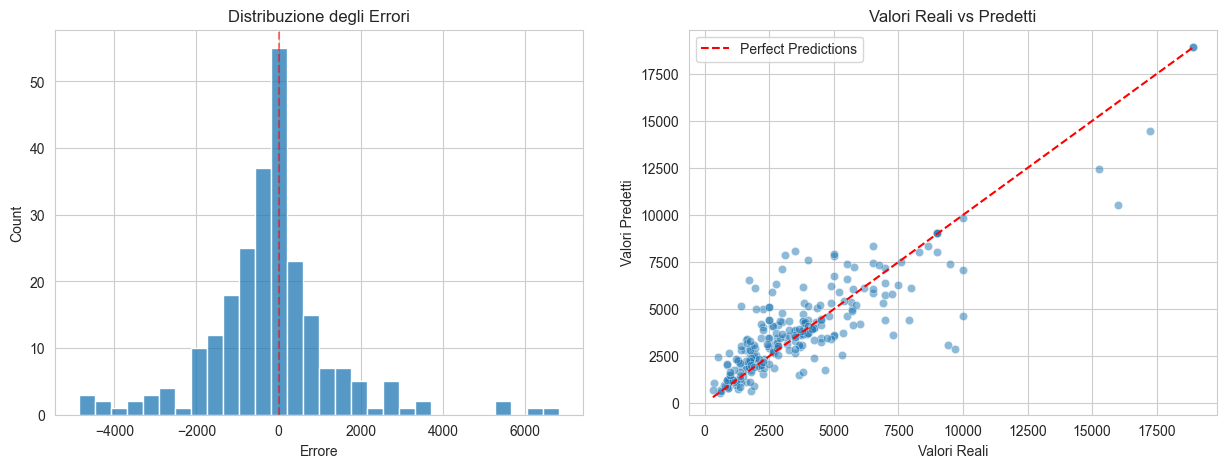

In [20]:
error_df, worst_cases = analyze_prediction_errors(y_test, y_pred, X_test)

In [21]:
ref_worst =df_.iloc[worst_cases.index.to_list()]
ref_worst

,name,year,Price,kms_driven,fuel_type,vehicle_type
677,Maruti Suzuki SX4 Celebration Diesel,2016,9700.0,85960,Diesel,Compact
410,Toyota Fortuner 3.0 4x4 MT,2010,9400.0,131000,Diesel,Off-road
511,Audi A6 2.0 TDI Premium,2012,15990.0,11500,Diesel,Sedan
14,Audi A8,2017,10000.0,4000,Petrol,Luxury
56,Honda City ZX CVT,2017,1700.0,15000,Diesel,Sedan
19,Mahindra Scorpio S10,2016,3100.0,39522,Diesel,SUV
508,Hyundai Verna Fluidic New,2012,3500.0,10000,Diesel,Sedan
468,Hyundai Verna 1.6 CRDI E,2016,1950.0,56000,Diesel,Sedan
783,Chevrolet Sail 1.2 LS,2013,3000.0,28000,Petrol,Sedan
442,Hyundai Eon Era Plus,2018,1400.0,2110,Petrol,Hatchback


In [22]:
ref_worst.merge(worst_cases[['Actual', 'Predicted', 'Error', 'Abs_Error']], on=ref_worst.index)

,key_0,name,year,Price,kms_driven,fuel_type,vehicle_type,Actual,Predicted,Error,Abs_Error
0,677,Maruti Suzuki SX4 Celebration Diesel,2016,9700.0,85960,Diesel,Compact,9700.0,2876.8999,6823.1001,6823.1001
1,410,Toyota Fortuner 3.0 4x4 MT,2010,9400.0,131000,Diesel,Off-road,9400.0,3075.6969,6324.3031,6324.3031
2,511,Audi A6 2.0 TDI Premium,2012,15990.0,11500,Diesel,Sedan,15990.0,10540.7995,5449.2005,5449.2005
3,14,Audi A8,2017,10000.0,4000,Petrol,Luxury,10000.0,4615.0988,5384.9012,5384.9012
4,56,Honda City ZX CVT,2017,1700.0,15000,Diesel,Sedan,1700.0,6562.7986,-4862.7986,4862.7986
5,19,Mahindra Scorpio S10,2016,3100.0,39522,Diesel,SUV,3100.0,7885.4995,-4785.4995,4785.4995
6,508,Hyundai Verna Fluidic New,2012,3500.0,10000,Diesel,Sedan,3500.0,8087.5991,-4587.5991,4587.5991
7,468,Hyundai Verna 1.6 CRDI E,2016,1950.0,56000,Diesel,Sedan,1950.0,6099.3987,-4149.3987,4149.3987
8,783,Chevrolet Sail 1.2 LS,2013,3000.0,28000,Petrol,Sedan,3000.0,7148.4979,-4148.4979,4148.4979
9,442,Hyundai Eon Era Plus,2018,1400.0,2110,Petrol,Hatchback,1400.0,5141.4988,-3741.4988,3741.4988


In [10]:
df['name'].str.split().str[0]

0        Hyundai
1       Mahindra
2        Hyundai
3           Ford
4           Ford
         ...    
812       Toyota
813         Tata
814     Mahindra
815        Honda
816    Chevrolet
Name: name, Length: 809, dtype: object

In [11]:
df['name'].str.split().str[1]


0        Santro
1          Jeep
2         Grand
3      EcoSport
4          Figo
         ...   
812     Corolla
813        Zest
814      Quanto
815       Amaze
816        Sail
Name: name, Length: 809, dtype: object

In [12]:
df['name'].str.split().str[2]

0          Xing
1         CL550
2           i10
3      Titanium
4           NaN
         ...   
812       Altis
813          XM
814          C8
815         1.2
816         1.2
Name: name, Length: 809, dtype: object